<a href="https://colab.research.google.com/github/Peris-Wallace/Stock-Markets-Analytics/blob/main/3.%20Modeling/%2003_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip uninstall gdown -y && pip install gdown
# !gdown -V

Found existing installation: gdown 5.2.0
Uninstalling gdown-5.2.0:
  Successfully uninstalled gdown-5.2.0
gdown 5.2.0 at /usr/local/lib/python3.11/dist-packages


In [3]:
# IMPORTS
import numpy as np
import pandas as pd
from math import sqrt

import yfinance as yf
import pandas_datareader as pdr

from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import (accuracy_score,
                            precision_score,
                            f1_score,
                            mean_squared_error)

import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import pyplot

import time
from datetime import date, datetime
import calendar

In [4]:
# Download the data
!gdown https://drive.google.com/file/d/1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB/view?usp=sharing --fuzzy -O /content/

Downloading...
From (original): https://drive.google.com/uc?id=1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB
From (redirected): https://drive.google.com/uc?id=1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB&confirm=t&uuid=a9476040-55d0-40ca-8da4-0a754e3ae560
To: /content/stocks_df_combined_2025_06_13.parquet.brotli
100% 130M/130M [00:01<00:00, 92.8MB/s]


In [128]:
# Load data
df_full = pd.read_parquet("/content/stocks_df_combined_2025_06_13.parquet.brotli", )

In [129]:
# growth indicators excluding future growth
GROWTH = [g for g in df_full.columns if g.startswith("growth_") and "future" not in g]

In [130]:
TO_PREDICT = [g for g in df_full.columns if "future" in g]

In [131]:
# Define categorical data
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type']

## **Question 1:** Dummies for Month and Week-of-Month
What is the **ABSOLUTE CORRELATION VALUE** of the most correlated dummy variable _w<week_of_month> with the binary outcome `is_positive_growth_30d_future`?

From the correlation analysis and modeling, you may have observed that October and November are potentially important seasonal months. In this task, you'll go further by generating dummy variables for both the Month and Week-of-Month (starting from 1). For example, the first week of October should be coded as: `'October_w1'`.

Once you've generated these new variables, identify the one with the highest absolute correlation with `is_positive_growth_30d_future`, and round the result to **three decimal places.**

**Suggested Steps**
1. Use this StackOverflow reference to compute the week of the month using the following formula:

  `(d.day - 1) // 7 + 1`
2. Create a new string variable that combines the month name and week of the month. Example: 'October_w1', 'November_w2', etc.

3. Add the new variable (e.g., `month_wom`) to your set of categorical features.

  Your updated categorical feature list should include:

  * `'Month'`
  * `'Weekday'`
  * `'Ticker'`
  * `'ticker_type'`
  * `'month_wom'`

4. Use pandas.get_dummies() to generate dummy variables for all categorical features.

  This should result in **approximately 115 dummy variables**, including around 60 for the month_wom feature (12 months × up to 5 weeks).

5. Use DataFrame.corr() to compute the correlation between each feature and the target variable `is_positive_growth_30d_future`.

6. Filter the correlation results to include only the dummy variables generated from `month_wom`.

7. Create a new column named `abs_corr` in the correlation results that stores the absolute value of the correlations.

8. Sort the correlation results by `abs_corr` in **descending order**.

9. Identify and report the **highest absolute correlation value** among the **month_wom dummy variables**, rounded **to three decimal places**.

In [136]:
# Clean up date variables
df_full['Month'] = df_full['Month'].dt.strftime('%B').astype('object')
df_full['Weekday'] = df_full['Weekday'].map(dict(enumerate(calendar.day_name)))

# Combine weeday and month variables
#df_full['Day_Month'] = df_full['Weekday'] + '_' + df_full['Month']

In [134]:
df_full['Date'] = pd.to_datetime(df_full['Date'])

# Create week of the month
week_of_month = df_full['Date'].apply(lambda d: 'w' + str((d.day - 1) // 7 + 1))
week_of_month.sample()

,Date
4778,w5


In [137]:
# Combine week number and month
df_full['Wom_Month'] = week_of_month + '_' + df_full['Month']
# df_full[['Month', 'Weekday', 'Day_Month', 'Wom_Month']].head()
df_full[['Month', 'Weekday', 'Wom_Month']].sample()

,Month,Weekday,Wom_Month
11018,January,Wednesday,w3_January


In [138]:
# CATEGORICAL = CATEGORICAL + ['Day_Month', 'Wom_Month']
CATEGORICAL = CATEGORICAL + ['Wom_Month']

In [15]:
OHLCV = ['Open','High','Low','Close','Adj Close_x','Volume']

In [17]:
# define log volume, avoid errors by adding log(1+x) when x = 0
df_full['ln_volume'] = np.log1p(df_full['Volume'])

In [19]:
# manually defined features
CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume']

In [20]:
# All Supported Ta-lib indicators: https://github.com/TA-Lib/ta-lib-python/blob/master/docs/funcs.md

TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo','roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk','fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr','ad','adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase','ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine','ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']

In [139]:
TECHNICAL_PATTERNS = [g for g in df_full.keys() if g.find('cdl')>=0]

In [22]:
MACRO = ['gdppot_us_yoy', 'gdppot_us_qoq', 'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS', 'DGS1', 'DGS5', 'DGS10']

In [23]:
NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO

In [24]:
TO_DROP = ['Year','Date','index_x', 'index_y', 'index', 'Quarter','Adj Close_y'] + CATEGORICAL + OHLCV

In [25]:
# CHECK: NO OTHER INDICATORS LEFT
OTHER = [k for k in df_full.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_PREDICT + TO_DROP]
print(OTHER)

['Close_x', 'Dividends', 'Stock Splits', 'Close_y']


In [26]:
df_full.Ticker.nunique()

33

In [140]:
# truncated df_full with 25 years of data
df = df_full[df_full.Date>='2000-01-01'].reset_index(drop=True)

### ***Generating dummies***

In [30]:
# Generate dummy variables
dummy_variables = pd.get_dummies(df[CATEGORICAL], dtype='int32')

In [31]:
dummy_variables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191795 entries, 0 to 191794
Columns: 115 entries, Month_April to Wom_Month_w5_September
dtypes: int32(115)
memory usage: 84.1 MB


In [32]:
# get dummies names in a list
DUMMIES = dummy_variables.keys().to_list()

In [33]:
# Concatenate the dummy variables with the original DataFrame
df_with_dummies = pd.concat([df, dummy_variables], axis=1)

In [35]:
df_with_dummies[NUMERICAL+DUMMIES].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191795 entries, 0 to 191794
Columns: 299 entries, growth_1d to Wom_Month_w5_September
dtypes: float64(121), int32(177), int64(1)
memory usage: 308.0 MB


### ***Correlation Analysis***

In [37]:
corr_is_positive_growth_30d_future = df_with_dummies[NUMERICAL+DUMMIES+TO_PREDICT].corr()['is_positive_growth_30d_future']

# create a dataframe for an easy way to sort
corr_is_positive_growth_30d_future_df = pd.DataFrame(corr_is_positive_growth_30d_future)

In [38]:
# Get absolute correlation
corr_is_positive_growth_30d_future_df['abs_corr'] = corr_is_positive_growth_30d_future_df['is_positive_growth_30d_future'].abs()

In [39]:
print(corr_is_positive_growth_30d_future_df.sort_values(by=['abs_corr'], ascending=False).round(3).head(15))

                               is_positive_growth_30d_future  abs_corr
is_positive_growth_30d_future                          1.000     1.000
growth_future_30d                                      0.696     0.696
DGS10                                                 -0.067     0.067
DGS5                                                  -0.060     0.060
gdppot_us_yoy                                         -0.058     0.058
gdppot_us_qoq                                         -0.058     0.058
growth_brent_oil_365d                                 -0.056     0.056
growth_epi_365d                                       -0.052     0.052
cpi_core_yoy                                          -0.045     0.045
growth_dji_365d                                       -0.041     0.041
cpi_core_mom                                          -0.041     0.041
growth_wti_oil_365d                                   -0.039     0.039
growth_dji_30d                                        -0.038     0.038
growth

In [40]:
print(corr_is_positive_growth_30d_future_df.sort_values(by=['abs_corr'], ascending=False).round(3).tail(20))

                     is_positive_growth_30d_future  abs_corr
Ticker_JPM                                   0.001     0.001
cdllongleggeddoji                           -0.001     0.001
Wom_Month_w4_May                            -0.001     0.001
cdlbreakaway                                -0.001     0.001
cdl3blackrows                                0.001     0.001
Ticker_HDB                                  -0.001     0.001
cdlgravestonedoji                            0.000     0.000
cdlxsidegap3methods                         -0.000     0.000
cdlhikkake                                   0.000     0.000
cdlrickshawman                              -0.000     0.000
Ticker_MSFT                                 -0.000     0.000
Wom_Month_w1_March                           0.000     0.000
growth_brent_oil_1d                         -0.000     0.000
Weekday_Monday                              -0.000     0.000
cdlstalledpattern                            0.000     0.000
growth_brent_oil_3d     

In [45]:
# Define wom_month dummies for correlation analysis
wom_month_dummies = [dummy for dummy in df_with_dummies.columns if dummy.startswith('Wom_Month_')]
print(len(wom_month_dummies))

60


In [46]:
corr_is_positive_growth_30d_future_wom = df_with_dummies[wom_month_dummies+TO_PREDICT[1:]].corr()['is_positive_growth_30d_future']

# Convert to dataframe for sorting
corr_is_positive_growth_30d_future_wom_df = pd.DataFrame(corr_is_positive_growth_30d_future_wom)

In [47]:
# Get absolute correlation
corr_is_positive_growth_30d_future_wom_df['abs_corr'] = corr_is_positive_growth_30d_future_wom_df['is_positive_growth_30d_future'].abs()


print(corr_is_positive_growth_30d_future_wom_df['abs_corr'].sort_values(ascending=False).round(3).head())

is_positive_growth_30d_future    1.000
Wom_Month_w4_October             0.025
Wom_Month_w3_November            0.022
Wom_Month_w2_November            0.019
Wom_Month_w2_January             0.018
Name: abs_corr, dtype: float64


The highest absolute value among the week of the month - month dummy variables is 0.025



---



### ***Temporal split of ~25 years of data (by date)***

In [48]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):

    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    # Add 'split' column to the DataFrame
    df['split'] = split_labels

    return df

In [49]:
min_date_df = df_with_dummies.Date.min()
max_date_df = df_with_dummies.Date.max()

df_with_dummies = temporal_split(df_with_dummies,
                                 min_date = min_date_df,
                                 max_date = max_date_df)

In [50]:
df_with_dummies['split'].value_counts(normalize=True)

,proportion
split,
train,0.676399
test,0.163758
validation,0.159843


# **Modeling**

In [51]:
# remove the "segmentation" problem (warning message on df performance after many joins and data transformations)
new_df = df_with_dummies.copy()

## ***Manual "hand rule" predictions***
* CCI (binary, on technical indicator CCI)
* growth_1d>1
* growth_1d>1 & growth_snp500_1d>1

In [65]:
# Let's label all prediction features with prefix "pred"
new_df['pred0_manual_cci'] = (new_df['cci']>200).astype(int)
new_df['pred1_manual_prev_g1'] = (new_df.growth_30d>1).astype(int)
new_df['pred2_manual_prev_g1_and_snp'] = ((new_df['growth_30d'] > 1) & (new_df['growth_snp500_30d'] > 1)).astype(int)



---



## **Question 2 :** Define New "Hand" Rules on Macro and Technical Indicator Variables
What is the precision score for the best of the NEW predictions (`pred3` or `pred4`), rounded to 3 digits?

In this task, you'll apply insights from the **visualized decision tree (clf10)** (see Code Snippet 5: 1.4.4 Visualisation) to manually define and evaluate new predictive rules.

1. Define two new 'hand' rules based on branches that lead to 'positive' predictions in the tree:

  * `pred3_manual_dgs10_5:
  (DGS10 <= 4) & (DGS5 <= 1)`
  *`pred4_manual_dgs10_fedfunds:
  (DGS10 > 4) & (FEDFUNDS <= 4.795)`

  Hint: This is not exactly the same condition as in the estimated tree (original: (DGS10 <= 4.825) & (DGS5 <= 0.745); (DGS10 > 4.825) & (FEDFUNDS <= 4.795)), since in that case, there are no true positive predictions for both variables. Consider why this might be the case.

2. Extend Code Snippet 3 (Manual "hand rule" predictions):

  * Implement and apply the above two rules (`pred3`, `pred4`) to your dataset.
  * Add the resulting predictions as new columns in your dataframe (e.g., new_df).

3. Compute precision:

  * For the rule that does make positive predictions on the TEST set, compute its **precision score**.
  * Use standard precision metrics (`TP / (TP + FP`)).
  * Round the precision score to **three decimal places.**

In [66]:
new_df['pred3_manual_dgs10_5'] = ((new_df['DGS10'] <= 4) & (new_df['DGS5'] <= 1)).astype(int)
new_df['pred4_manual_dgs10_fedfunds'] = ((new_df['DGS10'] > 4) & (new_df['FEDFUNDS'] <= 4.795)).astype(int)

In [68]:
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds']

In [75]:
# generate columns is_correct_
for pred in PREDICTIONS:
  part1 = pred.split('_')[0] # first prefix before '_'
  new_df[f'is_correct_{part1}'] =  (new_df[pred] == new_df.is_positive_growth_30d_future).astype(int)

In [76]:
# IS_CORRECT dataset
IS_CORRECT =  [k for k in new_df.keys() if k.startswith('is_correct_')]
IS_CORRECT

['is_correct_pred0',
 'is_correct_pred1',
 'is_correct_pred2',
 'is_correct_pred3',
 'is_correct_pred4']

In [77]:
# sample of a dataframe
new_df[PREDICTIONS+IS_CORRECT+['is_positive_growth_30d_future']].sample(5)

,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_dgs10_5,pred4_manual_dgs10_fedfunds,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4,is_positive_growth_30d_future
142243,0,1,0,0,0,0,1,0,0,0,1
140299,0,0,0,0,0,0,0,0,0,0,1
92037,0,1,1,0,0,1,0,0,1,1,0
132406,0,1,1,0,0,1,0,0,1,1,0
156648,0,1,1,1,0,0,1,1,1,0,1


In [78]:
len(new_df[new_df.split=='test'])

31408

In [79]:
# Define the columns for True Positives (TP) and False Positives (FP)
for i, column in enumerate(IS_CORRECT):
  prediction_column = PREDICTIONS[i]
  is_correct_column = column
  filter_predicted_positive = (new_df.split=='test') & (new_df[prediction_column]==1)

  # TP - When the prediction is 1 and the actual is 1 (is_correct == 1 when prediction is 1)
  tp = new_df[filter_predicted_positive][is_correct_column].sum()

  # FP - When the prediction is 1 and the actual is 0 (is_correct == 0 when prediction is 1)
  fp = len(new_df[filter_predicted_positive]) - tp

  # Calculate precision
  precision = tp / (tp + fp) if (tp + fp) > 0 else 0

  print(f'Prediction column: {prediction_column}')
  print(f'TP: {tp}, FP: {fp}')
  print(f'Precision: {precision:.3f}')
  print('-'*50)

Prediction column: pred0_manual_cci
TP: 443, FP: 351
Precision: 0.558
--------------------------------------------------
Prediction column: pred1_manual_prev_g1
TP: 9748, FP: 8243
Precision: 0.542
--------------------------------------------------
Prediction column: pred2_manual_prev_g1_and_snp
TP: 6984, FP: 6383
Precision: 0.522
--------------------------------------------------
Prediction column: pred3_manual_dgs10_5
TP: 578, FP: 419
Precision: 0.580
--------------------------------------------------
Prediction column: pred4_manual_dgs10_fedfunds
TP: 2640, FP: 3020
Precision: 0.466
--------------------------------------------------


 The precision score for the best of the new predictions is 0.580 (`pred4`)

## ***Binary Decision Tree***

**Define dataframes AND perform data cleaning**
* define X_train (dataframe), X_test (dataframe), y_train (series), y_test (series)
* replace +-inf. with 0
* fill NaNs with 0 (you can drop it too, but will loose a lot of data in our case
* remove 1-2% outliers (in each dimension, or only in variable to_predict :: we won't use it for a Decision Tree

In [145]:
pd.set_option('display.max_rows', None)
pd.set_option('display.precision', 4)

In [82]:
# Split the data into training and testing sets based on the split date
features_list = NUMERICAL + DUMMIES

to_predict = 'is_positive_growth_30d_future'

train_df = new_df[new_df.split.isin(['train','validation'])].copy(deep=True)
test_df = new_df[new_df.split.isin(['test'])].copy(deep=True)

# ONLY numerical Separate features and target variable for training and testing sets
# need Date and Ticker later when merging predictions to the dataset
X_train = train_df[features_list+[to_predict,'Date','Ticker']]
X_test = test_df[features_list+[to_predict,'Date','Ticker']]

print(f'length: X_train {X_train.shape},  X_test {X_test.shape}')

length: X_train (160387, 302),  X_test (31408, 302)


In [146]:
# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

# Need to fill NaNs somehow
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

In [84]:
X_train_imputed = X_train # we won't use outliers removal to save more data to train: remove_outliers_percentile(X_train)
X_test_imputed = X_test # we won't use outliers removal to save more data to test: remove_outliers_percentile(X_test)

In [85]:
y_train = X_train_imputed[to_predict]
y_test = X_test_imputed[to_predict]

# remove y_train, y_test from X_ dataframes
del X_train_imputed[to_predict]
del X_test_imputed[to_predict]

In [86]:
def fit_decision_tree(X, y, max_depth=10):
# Initialize the Decision Tree Classifier
  clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)

  # Fit the classifier to the training data
  clf.fit(X, y)
  return clf

In [87]:
clf_10 = fit_decision_tree(X=X_train_imputed.drop(['Date','Ticker'],axis=1),
                           y=y_train)

CPU times: user 1min 27s, sys: 713 ms, total: 1min 28s
Wall time: 51.5 s


### ***Inference for a Decision Tree***

In [147]:
def predict_decision_tree(clf:DecisionTreeClassifier, df_X:pd.DataFrame, y_true: pd.Series):
  # Predict the target variable on the test data
  y_pred = clf.predict(df_X)

  max_depth = clf.tree_.max_depth
  # Print the maximum depth
  print("Maximum depth of the decision tree:", max_depth)

  # Calculate the accuracy/precision of the model
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  print(f'Accuracy = {accuracy}, precision = {precision}')

  # resulting df
  result_df = pd.concat([df_X, y_true, pd.Series(y_pred, index=df_X.index, name='pred_')], axis=1)

  return result_df

In [148]:
pred10 = predict_decision_tree(clf_10, X_test_imputed.drop(['Date','Ticker'],axis=1), y_test)

Maximum depth of the decision tree: 10
Accuracy = 0.5583927661742232, precision = 0.5898212979412687




---



## **Question 3:** Unique Correct Predictions from a 10-Level Decision Tree Classifier (pred5_clf_10)

What is the total number of records in the **TEST** dataset where the new prediction `pred5_clf_10` is correct, while all 'hand' rule predictions (`pred0` to `pred4`) are incorrect?

To ensure reproducibility, please include the following parameter in the Decision Tree Classifier:

  ```clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)```

**Step 1: Train the Decision Tree and Generate Predictions**
  * Initialize a Decision Tree Classifier with a maximum depth of 10 and set `random_state=42` for reproducibility.
  * Fit the classifier on the combined TRAIN and VALIDATION datasets.
  * Use the trained model to predict on the entire dataset (TRAIN + VALIDATION + TEST).
  * Store these predictions in a new column named `pred5_clf_10` within your main dataframe.
  * Hint: When predicting on the entire dataset, it's easy to join the predictions with the full DataFrame, since the number of records and their order remain the same. You will need to define X_all and y_all and apply the same cleaning steps used previously for X_train, y_train, X_test, and y_test. This makes it straightforward to define a new column, for example:

    ```df['pred5_clf_10'] = <predictions vector from clf10.predict(X_all)>```

**Step 2: Identify Unique Correct Predictions by pred5_clf_10**
  * Create a new boolean column, `only_pred5_is_correct`, that is `True` only when:
    * The prediction from `pred5_clf_10` is correct (i.e., matches the true label).
    * All other hand rule predictions (`pred0` through `pred4`) are incorrect.

**Step 3: Count Unique Correct Predictions on the TEST Set**

  * Convert the `only_pred5_is_correct` column from boolean to integer.
  * Filter the dataframe for records belonging to the TEST dataset.
  * Count how many records in the **TEST set** have `only_pred5_is_correct` equal to 1.
  * Report this count as your final answer.

In [103]:
# Define the train columns for prediction
# Use the entire dataset
X_all = new_df[features_list+[to_predict,'Date','Ticker']]
X_all.fillna(0, inplace=True)

print(X_all.shape)

(191795, 302)


In [105]:
y_all = X_all[to_predict]
print(y_all.shape)

# remove y_all X_ dataframes
del X_all[to_predict]

(191795,)


In [107]:
# Predict on the entire dataset
# use the previously fitted model, train on train + validation dataset
new_df['pred5_clf_10'] = clf_10.predict(X_all.drop(['Date','Ticker'],axis=1))
new_df['pred5_clf_10'].value_counts()

,count
pred5_clf_10,
1,141988
0,49807


In [108]:
  accuracy = accuracy_score(new_df['pred5_clf_10'], y_all)
  precision = precision_score(new_df['pred5_clf_10'], y_all)
  f1 = f1_score(new_df['pred5_clf_10'], y_all)
  print(f'Accuracy = {accuracy}, Precision = {precision}, F1_score = {f1}')

Accuracy = 0.6960400427539821, Precision = 0.8679457643810562, F1_score = 0.7720187396857426


In [109]:
# Check if pred5_clf_10 is correct
new_df['is_correct_pred5_clf_10'] = (new_df['pred5_clf_10'] == new_df['is_positive_growth_30d_future']).astype(int)

new_df.groupby('split')['is_correct_pred5_clf_10'].value_counts()

split       is_correct_pred5_clf_10
test        1                          17538
            0                          13870
train       1                          92672
            0                          37058
validation  1                          23287
            0                           7370
Name: count, dtype: int64

In [110]:
 IS_CORRECT

['is_correct_pred0',
 'is_correct_pred1',
 'is_correct_pred2',
 'is_correct_pred3',
 'is_correct_pred4']

In [111]:
# Check if all hand rule predictions (pred0 to pred4) are incorrect
new_df['all_hand_rules_incorrect'] = (new_df[IS_CORRECT].sum(axis=1) == 0).astype(int)

# Create the new boolean column only_pred5_is_correct
new_df['only_pred5_is_correct'] = ((new_df['is_correct_pred5_clf_10'] == 1) & (new_df['all_hand_rules_incorrect'] == 1)).astype(int)

In [113]:
new_df.groupby('split')['only_pred5_is_correct'].value_counts()

split       only_pred5_is_correct
test        0                         27569
            1                          3839
train       0                        110503
            1                         19227
validation  0                         27007
            1                          3650
Name: count, dtype: int64



---



## **Question 4:** Hyperparameter tuning for a Decision Tree
What is the **optimal tree depth** (from 1 to 20) for a DecisionTreeClassifier?

**Instructions:**
  * Iterate through max_depth values from 1 to 20.
  * For each max_depth:
    * Train a Decision Tree Classifier with the current max_depth on the combined TRAIN+VALIDATION dataset.
  * Optionally, visualize how the 'head' (top levels) of each fitted tree changes with increasing tree depth.
    * You can use:
    `sklearn.tree.plot_tree()` for graphical visualization, or
    * The compact textual approach with export_text() function. For example:

      ```
      from sklearn.tree import export_text
      tree_rules = export_text(model, feature_names=list(X_train), max_depth=3)
      print(tree_rules)
      ```

  * Calculate the **precision score** on the TEST dataset for each fitted tree. You may also track precision on the VALIDATION dataset to observe signs of overfitting.
  * Identify the **optimal max_depth** where the precision score on the TEST dataset is highest. This value is your `best_max_depth`.
  * Using best_max_depth, retrain the Decision Tree Classifier on the combined TRAIN+VALIDATION set.
  * Predict on the entire dataset (TRAIN + VALIDATION + TEST) and add the predictions as a new column `pred6_clf_best` in your dataframe `new_df`.
  * Compare the precision score of the tuned tree with previous predictions (`pred0` to `pred5`). You should observe an improvement, ideally achieving precision > 0.58, indicating the tuned tree outperforms earlier models.

In [120]:
# Store precision scores
precision_scores_test = []

In [ ]:
for max_depth in range(1, 21):
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)

    # Training on train and validation datasets
    clf.fit(X_train_imputed.drop(['Date','Ticker'],axis=1), y_train)

    y_pred_test = clf.predict(X_test_imputed.drop(['Date','Ticker'],axis=1))
    precision_test = precision_score(y_test, y_pred_test)
    precision_scores_test.append(precision_test)

In [123]:
best_max_depth_index = precision_scores_test.index(max(precision_scores_test))
max_depths = range(1, 21)
best_max_depth = max_depths[best_max_depth_index]
print(f"\nOptimal max_depth based on test precision: {best_max_depth}")


Optimal max_depth based on test precision: 5


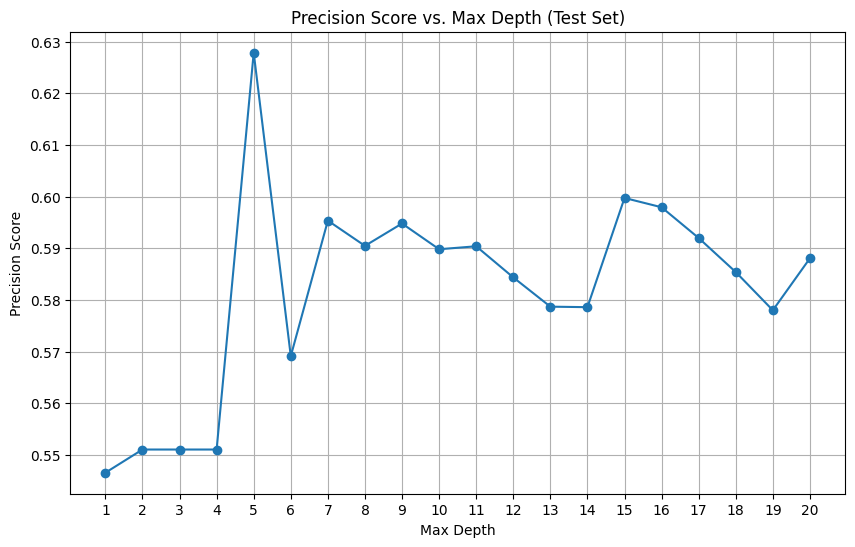

In [127]:
# Plot the precision scores against the max_depth values to detect saturation or overfitting trends.

plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), precision_scores_test, marker='o', linestyle='-')
plt.title('Precision Score vs. Max Depth (Test Set)')
plt.xlabel('Max Depth')
plt.ylabel('Precision Score')
plt.xticks(range(1, 21))
plt.grid(True)
plt.show()

In [ ]:
# Retrain with the best max_depth
clf_best = DecisionTreeClassifier(max_depth=best_max_depth, random_state=42)
clf_best.fit(X_train_imputed.drop(['Date','Ticker'],axis=1), y_train)

In [125]:
# Predict on the entire dataset
new_df['pred6_clf_best'] = clf_best.predict(X_all.drop(['Date','Ticker'],axis=1))

In [126]:
# Evaluate the best model
accuracy_best = accuracy_score(new_df['pred6_clf_best'], y_all)
precision_best = precision_score(new_df['pred6_clf_best'], y_all)
f1_best = f1_score(new_df['pred6_clf_best'], y_all)
print(f"\nBest Model Performance (max_depth={best_max_depth}) on All Data:")
print(f"Accuracy = {accuracy_best:.3f}, Precision = {precision_best:.3f}, F1_score = {f1_best:.3f}")


Best Model Performance (max_depth=5) on All Data:
Accuracy = 0.635, Precision = 0.832, F1_score = 0.730
